__Forward encoding model based on Pim Mostert Decoding toolbox__

Alexis Pérez Bellido (2022)

In [1]:
!pwd

/Users/junjieji/Desktop/master-thesis


In [2]:
import sys
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)
# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import DecToolbox as dt
import mne
import os
import random

from statsmodels.tsa.stattools import coint¶


Decoding modules

In [3]:
''' VARIABLE '''

numC = 8

kappa = 4
use_EEG = True
shuffle_X = False
use_labels = False
less_data = False
amount_data = 1000

cfg_stim = dict()
cfg_stim['kappa'] = kappa
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'halfRectCos'#'vonmises' 
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.01
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])

Loading & preparing orientation data

In [4]:
path = 'decoding-toolbox_matlab/data/testdata_orientation.mat' 
ori_data = mat73.loadmat(path)

In [5]:
Y = ori_data['Y']
X = ori_data['X']
time = ori_data['time']
label = ori_data['label']

In [6]:
print(X.shape, Y.shape)

(760,) (273, 211, 760)


In [7]:
if not use_EEG:
    EEG = False
else: 
    EEG = True
subjs_list = ['s01', 
              's02',
               's03' ,'s04','s05','s07','s08'
               # ,'s09','s10','s11','s12','s13','s14', 's15', 's16','s17','s18','s19','s20','s21','s22','s23','s24','s25','s26','s27' 
                ]
if EEG:
    
    path = 'Cond_CJ_EEG'

    epochs = []
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
        epochs.append(epoch.average());
        # print(isubj)

    gvaverage = mne.grand_average(epochs[:])
    all_epochs = []
    all_rawdata = [None] * np.size(subjs_list)
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
        subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
        all_rawdata[isubj] =  subj_data
        all_epochs.append(epoch);
        epoch.metadata
    all_st_epochs = []
    all_st_rawdata = [None] * np.size(subjs_list)
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/mainstim_epo.fif',verbose=False)
        subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
        all_st_rawdata[isubj] =  subj_data
        all_st_epochs.append(epoch);
        epoch.metadata

    one = True
    if one:
        ival = 6
        YY = all_st_rawdata[ival]['epoch_dat']
        YY = np.einsum('kji->jik', YY)
        XX = np.array(all_st_rawdata[ival]['metadata'].orient)
        tt = all_st_epochs[ival].times
        ll = all_st_epochs[ival].ch_names

        print(min(XX), max(XX))
        print(XX.shape)
        new_XX = np.digitize(XX, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) )-1.
    else:
        ival = 0
        YY = all_st_rawdata[ival]['epoch_dat']
        YY = np.einsum('kji->jik', YY)
        XX = np.array(all_st_rawdata[ival]['metadata'].orient)
        tt = all_st_epochs[ival].times
        ll = all_st_epochs[ival].ch_names
        for ival in range(1, len(subjs_list)):
            YY2 = all_st_rawdata[ival]['epoch_dat']
            YY2 = np.einsum('kji->jik', YY2)
            XX2 = np.array(all_st_rawdata[ival]['metadata'].orient)
            tt2 = all_st_epochs[ival].times

            YY = np.concatenate((YY,YY2),axis=2)
            XX = np.concatenate((XX,XX2),axis=0)
            tt = np.concatenate((tt,tt2),axis=0)
        new_XX = np.digitize(XX, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) )-1.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Identifying common channels ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pi

In [14]:
if use_EEG:
    X = new_XX
    YY = np.delete(YY,25,axis=0)
    Y = YY
    time = tt
    label = ll

# labels = ()
# if use_labels:
#     
#     Y = Y[:,:,(X == 0)+(X==1)+(X==2)]
#     X = X[(X == 0)+(X==1)+(X==2)]
# 
# print(X.shape, Y.shape)
# 
# import random
# if shuffle_X:
#     random.shuffle(X)
# if less_data:
#     
#     Y = Y[:,:,0:amount_data]
#     X = X[0:amount_data]
#     time = time[0:amount_data]
# print(X.shape, Y.shape)

In [18]:
phi = X * (180./8);   # Presented orientation in degrees

binned_phi = np.digitize(phi, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) ) # bins collapsing degrees by similarity

numF = Y.shape[0];
numT = Y.shape[1];
numN = Y.shape[2];

numC = 8 # how many channels to use
print(numN)

1528


In [19]:
sel_t = np.where(time >=.2)[0][0];
#sel_t = 170
print(sel_t)

150


In [20]:
G = binned_phi.copy()
CONDS = np.unique(G);
nConds = CONDS.size
nfold = 2
FoldsIdx = dt.CreateFolds(G, Y, nfold)

dat = dict()
dat['X_train'] = G[ FoldsIdx[0]['train_index']]
dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['train_index']])
dat['phi_train'] = phi[ FoldsIdx[0]['train_index']]

dat['X_test'] = G[ FoldsIdx[0]['test_index']]
dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['test_index']])
dat['phi_test'] = phi[ FoldsIdx[0]['test_index']]

design, sortedesign = dt.stim_features(dat['phi_train'], cfg_stim)
decoder = dt.train_encoder(design, dat['Y_train'], cfg_train)

Xhat = dt.test_encoder( decoder, dat['Y_test'], cfg_test)

In [21]:
print(decoder['dmY'].shape)
print(decoder['W'].shape)
print(decoder['iW'].shape)
print(decoder['pattern'].shape)

(30, 1)
(8, 30)
(8, 30)
(30, 8)


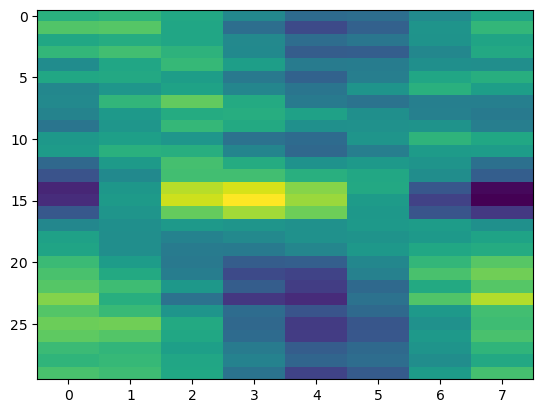

In [24]:
plt.imshow(decoder['pattern'],aspect='auto')

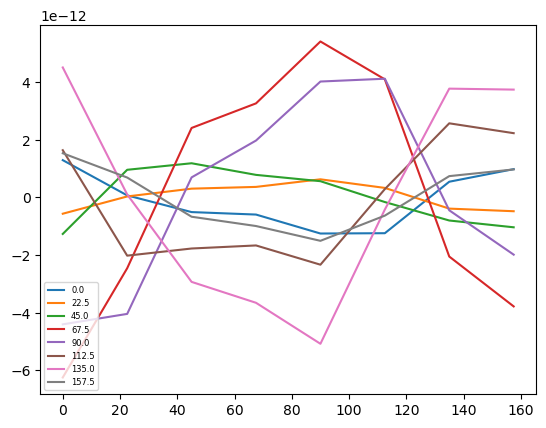

In [25]:
m = np.zeros((numC,numC))
for ic in range(numC):
    m[:,ic] =  np.mean( Xhat[:, np.where(dat['X_test'] == (ic+1))[0]], axis = 1)
plt.plot(x_labels, m)
plt.legend(x_labels, loc=3, prop={'size': 6})


__Preparing data for plotting results__

Re-alligning predictions for trials with identical orientation

In [26]:
Xhat_centered = 0*Xhat.copy()
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:,np.where(dat['X_test'] == (ic+1))] = np.roll(Xhat[:,np.where(dat['X_test'] == (ic+1))], -ic, axis = 0)

In [27]:
m_centered = np.zeros((numC,numC))
for ic in range(numC):
   m_centered[:,ic] =  np.mean( Xhat_centered[:, np.where(dat['X_test'] == (ic+1))[0]], axis = 1)

In [28]:
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [29]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

0.10000683760819641

Getting mean orientation values for each stimulus bin

In [30]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[np.where(dat['X_test'] == (ic+1))[0]] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

# Plotting results

[Text(0.0, 0, '0.0'),
 Text(22.5, 0, '22.5'),
 Text(45.0, 0, '45.0'),
 Text(67.5, 0, '67.5'),
 Text(90.0, 0, '90.0'),
 Text(112.5, 0, '112.5'),
 Text(135.0, 0, '135.0'),
 Text(157.5, 0, '157.5')]

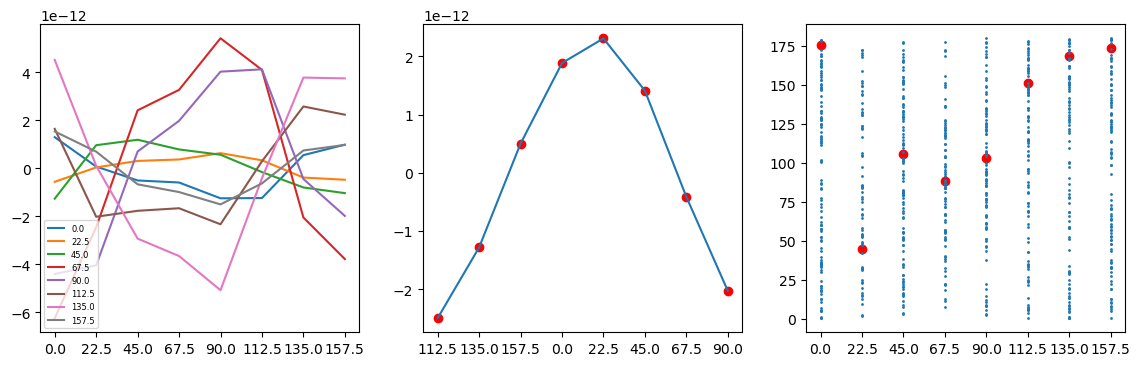

In [31]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(dat['phi_test'], theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


In [32]:
# stop

np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2))

__Preparing crossvalidation procedure__

In [33]:
import DecToolbox as dt
from importlib import reload  # Python 3.4+
reload(dt)

<module 'DecToolbox' from '/Users/junjieji/Desktop/master-thesis/DecToolbox.py'>

In [34]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

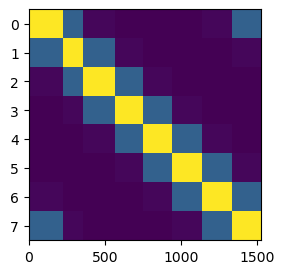

In [35]:
numC = 8 # how many channels to use

cfg = dict()
cfg['kappa'] = kappa
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(phi, cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [36]:
from DecToolbox import CV_encoder
cfg = dict()
cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
cfg['cfgD'] = {'demean' : 'traindata'}
Xhat = CV_encoder(design, Y, sel_t, cfg, FoldsIdx)

In [37]:
m = np.zeros((numC,numC))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1)], axis = 1)

Re-alligning predictions for trials with identical orientation

In [38]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1)] = np.roll(Xhat[:,G == (ic+1)], -ic, axis = 0)
    m_centered[:,ic] =  np.mean( Xhat_centered[:,  G == (ic+1)], axis = 1)

In [39]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [40]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

0.14297255183917343

Getting mean orientation values for each stimulus bin

In [41]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[G == (ic+1)] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

# Plotting results

[Text(0.0, 0, '0.0'),
 Text(22.5, 0, '22.5'),
 Text(45.0, 0, '45.0'),
 Text(67.5, 0, '67.5'),
 Text(90.0, 0, '90.0'),
 Text(112.5, 0, '112.5'),
 Text(135.0, 0, '135.0'),
 Text(157.5, 0, '157.5')]

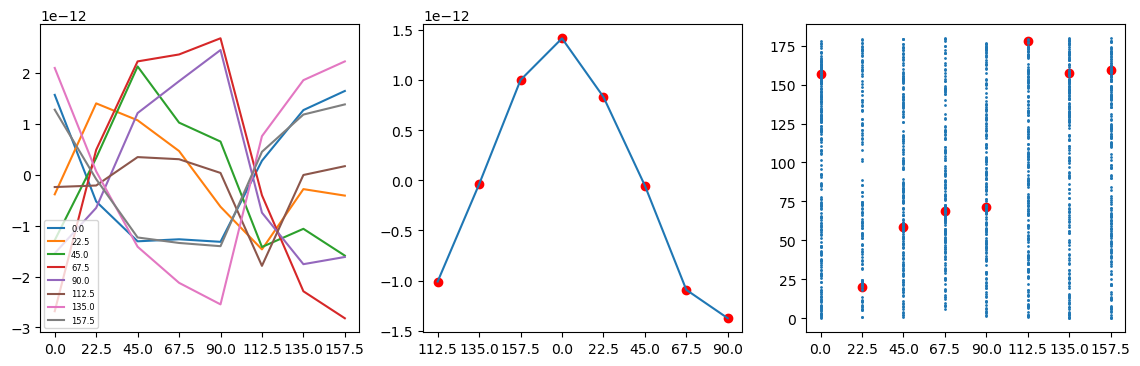

In [42]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(phi, theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


# Temporal dimension decoding

In [43]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

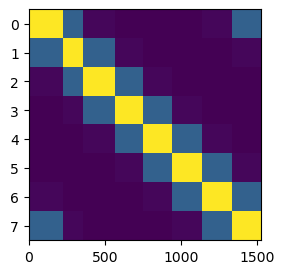

In [44]:
numC = 8 # how many channels to use

cfg = dict()
cfg['kappa'] = 4
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(phi, cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [45]:
# print(crossval)

In [46]:
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it] = dt.CV_encoder(design, Y, it, cfg, FoldsIdx)

In [47]:
m = np.zeros((numC,numC, numT))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1),:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [48]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:] = np.roll(Xhat[:,G == (ic+1),:], -ic, axis = 0)
    m_centered[:,ic, : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :], axis = 1)

In [49]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

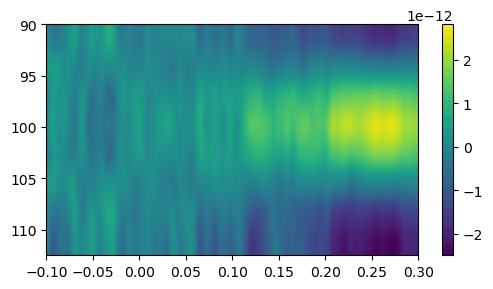

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Xhat_shiftedmean,aspect='auto', interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()

__Crossmodal temporal generalization decoding__

In [51]:
import time as tic


In [52]:
start = tic.time()
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it, :] = dt.CV_TG_encoder(design, Y, it, cfg, FoldsIdx)
end = tic.time()

'''
macbook M1 speed
Takes 4 min for matlab dataset
takes 1 min for eeg dataset
'''

'\n4m mac\n'

In [57]:
m = np.zeros((numC, numC, numT, numT))
for ic in range(numC):
   m[:,ic, :, :] =  np.mean( Xhat[:, G == (ic+1),:,:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [58]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:, :] = np.roll(Xhat[:,G == (ic+1),:, :], -ic, axis = 0)
    m_centered[:,ic, : , : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :, :], axis = 1)

'''1 min mac'''

Plotting diagonal values

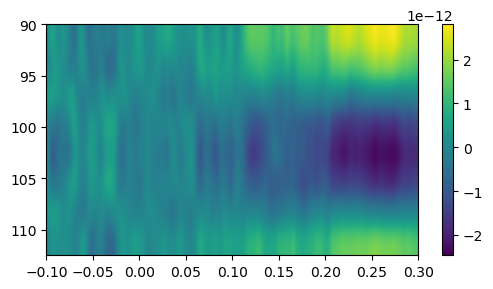

In [60]:
diagonal_vals =  m_centered[:,:,range(numT),range(numT)]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(np.mean(diagonal_vals, axis = 1),aspect='auto', interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()

Correlation between actual and predicted orientation values

In [61]:
r = np.zeros((numT, numT))

for it1 in range(numT):
    for it2 in range(numT):
        # Kernel to back project channel outputs to orientation space
        kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
        Z = kernel @ Xhat[:,:, it1, it2]

        theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

        rs = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
        r[it1, it2] = np.abs(rs) * np.cos(np.angle(rs))
        r
'''1 min mac'''

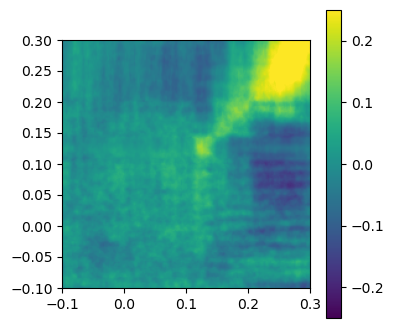

In [62]:
time_labels = [0, 0.2, 0.4, 0.6]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.imshow(r, aspect= 1, interpolation = None, vmin = -0.25, vmax = 0.25, origin = 'lower',extent=[time[0],time[-1],time[0],time[-1]])
plt.colorbar()
#ax.set_xticklabels(time_labels)
#ax.set_yticklabels(time_labels)

Getting mean orientation values for each stimulus bin

# Plotting results

In [63]:
# Creating dat containing test and train indexes
nfold = 2

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=nfold,shuffle=False)
CrossValIdx = [None] * nfold
i = 0
for train_index, test_index  in  skf.split(X = np.zeros(numN), y = X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    CrossValIdx[i] = { 'train_index': train_index, 'test_index': test_index}
    i += 1

X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]
X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [64]:

X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]
X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [65]:
# G[dat[0].astype(int)]

In [66]:
dat = [np.array([])]*nfold

for iCond in range(nConds):
    # Find indexes
    indx = np.where(G == CONDS[iCond])[0]
    n_indx = indx.size 
    # Shuffle indexes
    indx = np.random.permutation(indx)
    # Distribute across dat
    nelemxfold = np.floor(indx.size/nfold)
    groupNumber = np.repeat(np.arange(0,nfold), nelemxfold)

    for iFold in range(nfold):
        dat[iFold] = np.append(dat[iFold], indx[np.where(groupNumber == iFold)])

 

In [67]:
indx[np.where(groupNumber == iFold)]

array([1224, 1262,  467,  613,  418,  491,  973,  548, 1143,   55,  608,
        535,  714, 1385,  440, 1320, 1088,  190,   46, 1241,  263, 1147,
        353,  815,  593,   90,   95,  269,  977,  899,   10,  497,  544,
       1025,  961,  928, 1216, 1210,  495, 1096,  242,  511,  542, 1477,
        196,  692, 1269, 1340,   27,   49, 1324,  854, 1094,  229,  463,
        313,   15,  355,  241,   21, 1363, 1275, 1361,  700, 1202, 1342,
        319, 1032,  730,  637,   81,  739, 1268,  729, 1263,  446,  599,
        489, 1396,  979,  971,  809,  698,  940,  551,  572, 1492,   40,
        783, 1315, 1330,  516,  631,  814, 1010,  779,  904, 1384, 1163,
        248])